### Amazon Reviews - Sentiment Analysis

#### Import relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use ('ggplot')
import nltk

#### Read the data

In [ ]:
df = pd.read_csv ('Reviews.csv')
df.head()

#### Check for null entries

In [ ]:
null_values = df.isnull()
null_counts = null_values.sum()
null_counts

#### Data Pre-processing

In [ ]:
df.shape

In [ ]:
df= df.head(500)
df.shape

#### Exploratory Data Analysis

In [ ]:
ax= df['Score'].value_counts().sort_index() \
      .plot(kind='bar', title = 'Count of Reviews by Stars', 
            figsize =(10,5))

ax.set_xlabel ('Star Rating')
ax.set_ylabel ('Count')
plt.show

### Basic NLTK

In [ ]:
nltk.download('vader_lexicon')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
example = df ['Text'] [49]
print (example)

#### Tokenization

In [ ]:
tokens= nltk.word_tokenize (example)
tokens[:10]

#### POS Tagging

In [ ]:
tagged= nltk.pos_tag(tokens)
tagged[:10]

#### Name Entity Recogniion

In [ ]:
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

### VADER Sentiment Scoring

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia= SentimentIntensityAnalyzer ()

In [ ]:
sia.polarity_scores ("I am very happy" )

In [ ]:
sia.polarity_scores ("This is the worst food ever")

In [ ]:
sia.polarity_scores(example)

#### Run Polarity score on entire data set

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total = len (df)):
    text= row ['Text']
    myid= row ['Id']
    res [myid]= sia.polarity_scores(text)

In [ ]:
vaders= pd.DataFrame(res).T
vaders= vaders.reset_index().rename(columns ={'index':'Id'})
vaders=vaders.merge(df, how='left')

In [ ]:
vaders.head()

### Plot VADER results

In [ ]:
ax= sns.barplot(data=vaders, x= 'Score', y='compound')
ax.set_title ('Compound Scores for Amazon Reviews')

In [ ]:
fig, axs = plt.subplots (1,3 ,figsize=(15,3))
sns.barplot(data=vaders, x= 'Score', y='pos', ax=axs [0])
sns.barplot(data=vaders, x= 'Score', y='neu', ax=axs [1])
sns.barplot(data=vaders, x= 'Score', y='neg', ax=axs [2])
axs[0].set_title ('Positive')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('polarity')

axs[1].set_title ('Neutral')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('polarity')

axs[2].set_title ('Negative')
axs[2].set_xlabel('Rating')
axs[2].set_ylabel('polarity')

plt.show()

### Roberta Pretrained Model

##### Install relevant modules

In [ ]:
!pip install torch  
!pip install tensorflow   
!pip install flax 

In [ ]:
!pip install --upgrade tensorflow-intel
!pip install ml-dtypes==0.2.0

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

##### Initialize model

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"  
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#### VADER results on example

In [49]:
print (example)
sia.polarity_scores (example )

This is the same stuff you can buy at the big box stores.  There is nothing healthy about it.  It is just carbs and sugars.  Save your money and get something that at least has some taste.


{'neg': 0.056, 'neu': 0.865, 'pos': 0.079, 'compound': 0.2363}

#### Run for Roberta model 

In [50]:
encoded_text = tokenizer (example, return_tensors= 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores [0],
    'roberta_neu' : scores [1],
    'roberta_pos' : scores [2]
}
print (scores_dict)

{'roberta_neg': 0.90213436, 'roberta_neu': 0.08792557, 'roberta_pos': 0.009940095}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer (example, return_tensors= 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores [0],
        'roberta_neu' : scores [1],
        'roberta_pos' : scores [2]
    }
    return (scores_dict)

In [51]:
res = {}
for i, row in tqdm(df.iterrows(), total = len (df)):
    try: 
        text= row ['Text']
        myid= row ['Id']
        vader_result= sia.polarity_scores(text)
        vader_result_rename = {}
        for key , value in vader_result.items():
            vader_result_rename [f"vader_{key}"]= value
        roberta_result = polarity_scores_roberta(text)
        both= {**vader_result_rename,**roberta_result}
        res[myid]=both
    except RuntimeError :
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [52]:
both

{'vader_neg': 0.0,
 'vader_neu': 0.678,
 'vader_pos': 0.322,
 'vader_compound': 0.9811,
 'roberta_neg': 0.0024397583,
 'roberta_neu': 0.011327226,
 'roberta_pos': 0.986233}

In [53]:
results_df= pd.DataFrame(res).T
results_df= results_df.reset_index().rename(columns ={'index':'Id'})
results_df=results_df.merge(df, how='left')
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Compare Scores Between Models

In [54]:
results_df.columns


Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

C:\Users\user\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


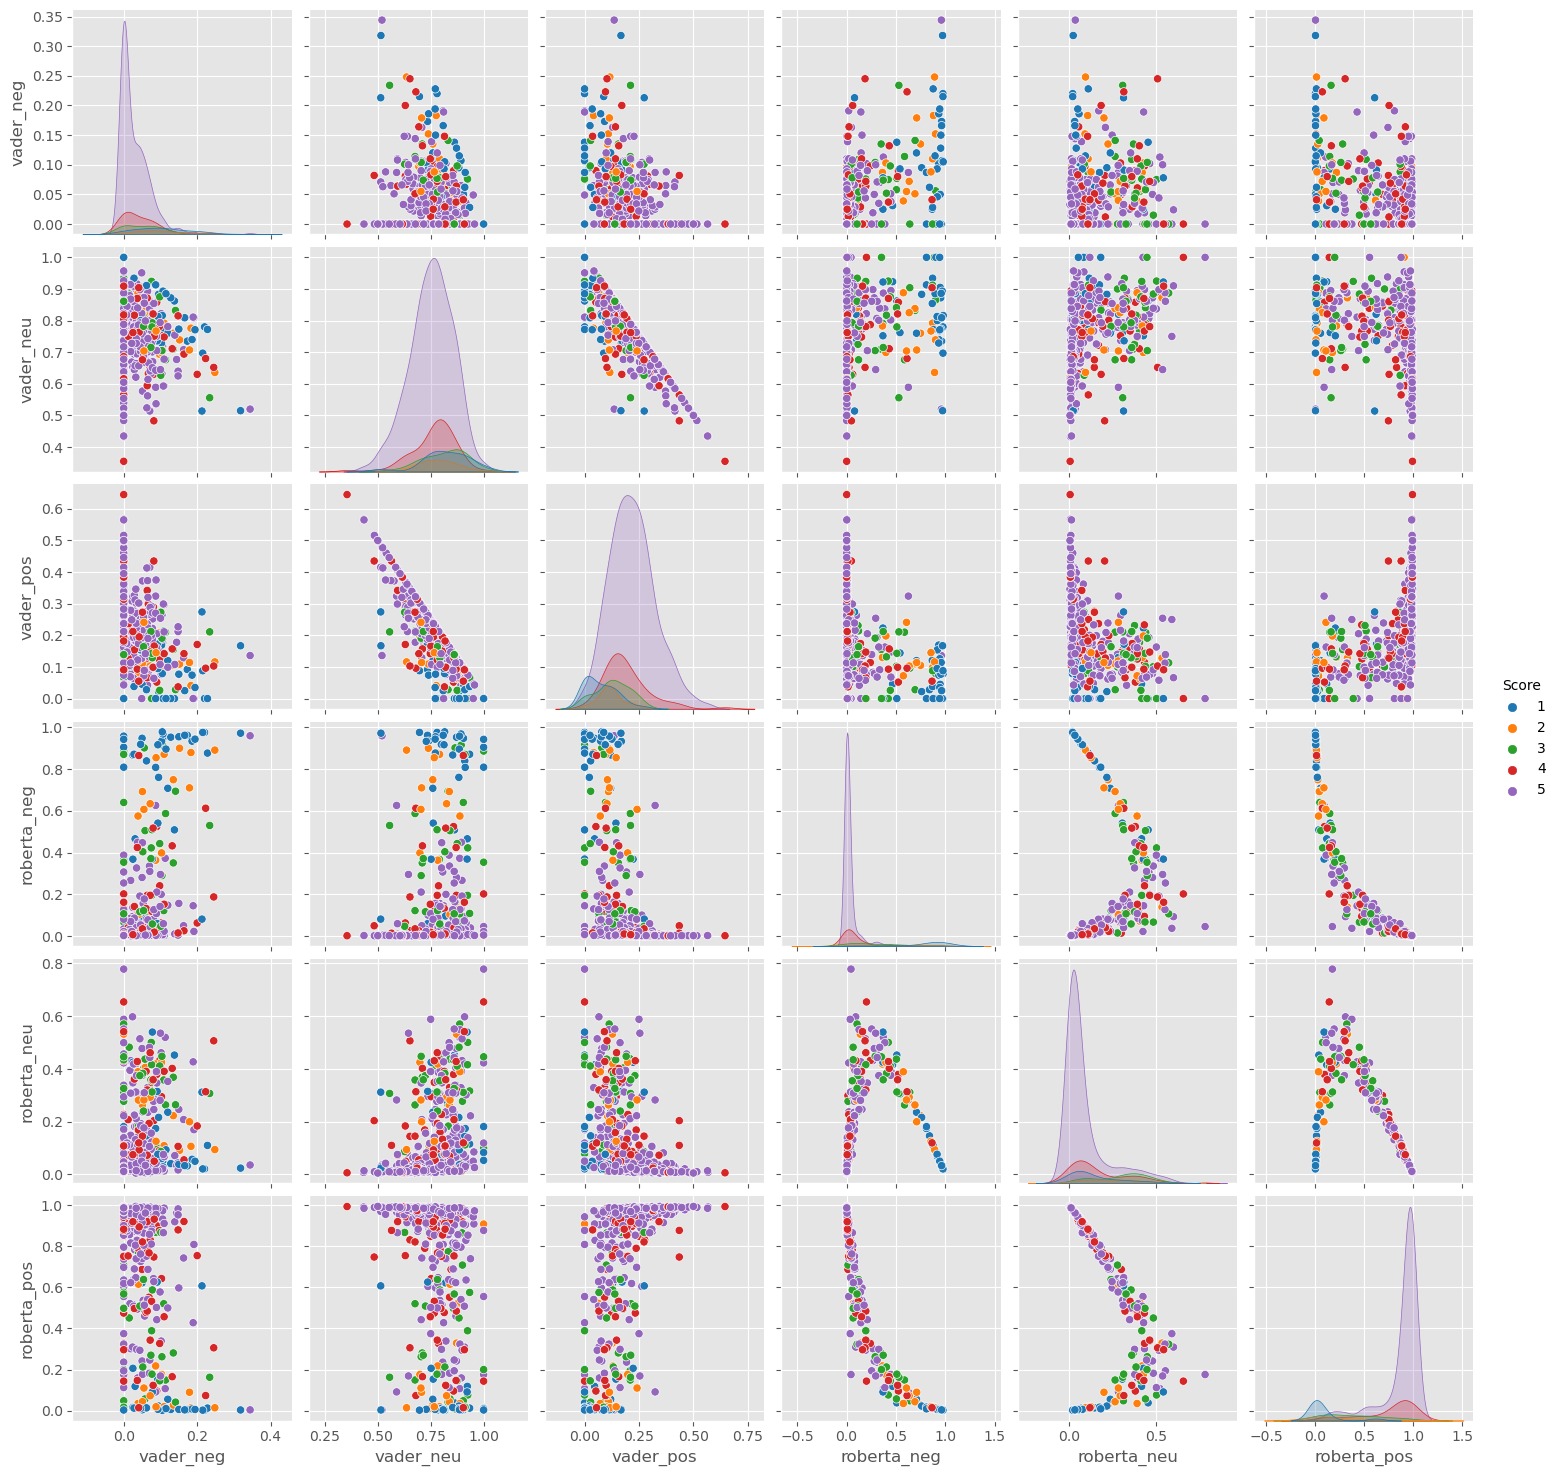

In [56]:
sns.pairplot (data = results_df, vars= ['vader_neg', 'vader_neu', 'vader_pos',
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
                    hue= 'Score', palette = 'tab10')
plt.show()

### Review Examples

In [ ]:
results_df.query('Score == 1').sort_values ('roberta_pos', ascending = False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1').sort_values ('vader_pos', ascending = False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5').sort_values ('roberta_neg', ascending = False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5').sort_values ('vader_neg', ascending = False)['Text'].values[0]

### The Transformers Pipeline

In [ ]:
from transformers import pipeline
sent_pipeline = pipeline ("sentiment-analysis")

In [ ]:
sent_pipeline ('I hate people pleasing' )

In [ ]:
sent_pipeline ('I love dogs' )

In [ ]:
sent_pipeline ('Subscribe to my channel' )